In [2]:
import os
import numpy as np
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D
from PIL import Image, ImageChops, ImageEnhance
import cv2

In [3]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

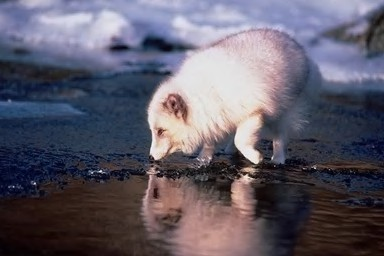

In [4]:
real_image_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au/Au_ani_00041.jpg'
Image.open(real_image_path)

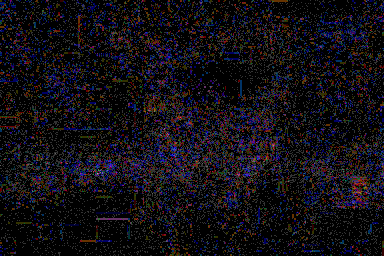

In [5]:
convert_to_ela_image(real_image_path, 95)

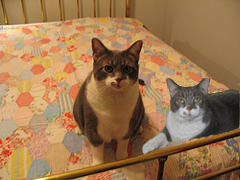

In [6]:
fake_image_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_D_CRD_S_O_ani10103_ani10111_10637.jpg'
Image.open(fake_image_path)

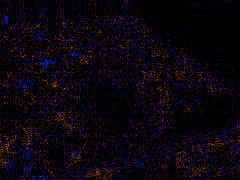

In [7]:
convert_to_ela_image(fake_image_path, 90)

In [8]:
image_size = (224, 224)

In [9]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [10]:
X = []
y = []

In [11]:
import random

path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'
print(os.walk(path))
for root, dirs, files in os.walk(path):
  for filename in files:
    file_path = os.path.join(root, filename)
    if filename.lower().endswith(('jpg', 'png')):
      X.append(prepare_image(file_path))
      y.append(1)
    if len(X)==3000:
        break

random.shuffle(X)

print(len(X), len(y))

<generator object _walk at 0x7f0ec4934a50>
3000 3000


In [12]:
import random
#count = 0
path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'
for root, dirs, files in os.walk(path):
    for filename in files:
        file_path = os.path.join(root, filename)
        if filename.lower().endswith(('jpg', 'png', 'tif', 'tiff')):
            X.append(prepare_image(file_path))
            y.append(0)
        if len(X)==4500:
            break

In [13]:
from keras.utils import to_categorical
X = np.array(X)
y = to_categorical(y, 2)
X = X.reshape(-1, 224, 224, 3)

In [14]:
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.2, random_state=5)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3600 3600
900 900


In [15]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5,mode='max', restore_best_weights=True)

In [16]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from keras.models import Sequential

In [17]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (224, 224, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu',))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu',))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [19]:
from keras.layers import BatchNormalization
model = build_model()

In [22]:
epochs = 15
batch_size = 32
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [23]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.7715 - loss: 3.8019 - val_accuracy: 0.3411 - val_loss: 6.8370
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.7391 - loss: 0.5766 - val_accuracy: 0.3411 - val_loss: 6.4979
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.7444 - loss: 0.6560 - val_accuracy: 0.3411 - val_loss: 4.0218
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.7385 - loss: 0.4222 - val_accuracy: 0.5056 - val_loss: 1.3390
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.7778 - loss: 0.4183 - val_accuracy: 0.4389 - val_loss: 0.6754
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.8099 - loss: 0.3918 - val_accuracy: 0.8156 - val_loss: 0.8014
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.8135 - loss: 0.4022 - val_accuracy: 0.7144 - val_loss: 0.8465
Epoch 8/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 346s 3s/step - accuracy: 0.8338 - loss: 0.3605 - val_accu

In [24]:
model.evaluate(X_val,Y_val)

29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 562ms/step - accuracy: 0.8627 - loss: 0.3284


[0.4327186346054077, 0.8533333539962769]

29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 566ms/step
Classification Report:
               precision    recall  f1-score   support

    Tampered       0.75      0.86      0.80       307
   Authentic       0.92      0.85      0.88       593

    accuracy                           0.85       900
   macro avg       0.83      0.85      0.84       900
weighted avg       0.86      0.85      0.86       900



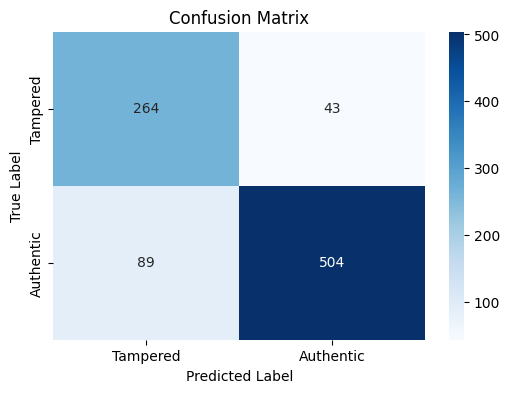

In [37]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Get predicted labels
y_pred_probs = model.predict(X_val)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Step 2: Get true labels from one-hot encoded Y_val
y_true_labels = np.argmax(Y_val, axis=1)

# Step 3: Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Step 4: Print classification report
print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels, target_names=["Tampered", "Authentic"]))

# Step 5: Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Tampered", "Authentic"], yticklabels=["Tampered", "Authentic"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,353,928 (295.08 MB)

 Trainable params: 25,784,514 (98.36 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 51,569,030 (196.72 MB)

In [26]:
# make predictions on the validation set
y_pred = model.predict(X_val)
# print the first 10 predictions
print(y_pred[:10])

29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 560ms/step
[[3.9556683e-03 9.9604428e-01]
 [4.9226356e-10 9.9999994e-01]
 [8.3251613e-01 1.6748376e-01]
 [9.0220952e-01 9.7790509e-02]
 [0.0000000e+00 9.9999994e-01]
 [3.5313345e-02 9.6468663e-01]
 [4.7837437e-07 9.9999946e-01]
 [8.4097254e-01 1.5902741e-01]
 [2.5254865e-06 9.9999744e-01]
 [8.4697801e-01 1.5302198e-01]]


In [27]:
# get the predicted labels
y_pred_labels = np.argmax(y_pred, axis=1)
# print the first 10 labels
print(y_pred_labels[:10])

[1 1 0 0 1 1 1 0 1 0]


In [28]:
# Save model
model.save("image_forgery_detection_model.keras")

In [29]:
#Load the model
from tensorflow import keras
model = keras.models.load_model('/kaggle/working/image_forgery_detection_model.keras')

In [30]:
# make predictions on the validation set
y_pred = model.predict(X_val)
# print the first 10 predictions
print(y_pred[:10])

29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 550ms/step
[[3.9556683e-03 9.9604428e-01]
 [4.9226356e-10 9.9999994e-01]
 [8.3251613e-01 1.6748376e-01]
 [9.0220952e-01 9.7790509e-02]
 [0.0000000e+00 9.9999994e-01]
 [3.5313345e-02 9.6468663e-01]
 [4.7837437e-07 9.9999946e-01]
 [8.4097254e-01 1.5902741e-01]
 [2.5254865e-06 9.9999744e-01]
 [8.4697801e-01 1.5302198e-01]]


In [31]:
from PIL import Image
import numpy as np
from keras.models import load_model

In [ ]:
# Load the trained model
# model = keras.models.load_model('image_forgery_detection_model.keras')

In [32]:
# Function to preprocess image using ELA
def preprocess_image(image_path):
    # Load the image
    image = Image.open(image_path)
    
    # Convert the image to ELA format
    ela_image = convert_to_ela_image(image_path, quality=90)
    
    # Resize and normalize the ELA image
    ela_image = ela_image.resize((224, 224))
    ela_array = np.array(ela_image).reshape(-1, 224, 224, 3) / 255.0
    
    return ela_array

In [33]:
# Function to predict if image is tampered or not
def predict_tampered(image_path):
    # Preprocess the input image
    processed_image = preprocess_image(image_path)
    
    # Make prediction using the trained model
    prediction = model.predict(processed_image)
    
    # Extract predicted class (0 for tampered, 1 for authentic)
    predicted_class = np.argmax(prediction)
    
    # Return the prediction result
    if predicted_class == 0:
        return "Tampered"
    else:
        return "Authentic"

In [34]:
input_image_path = "/kaggle/input/unseen-images/pic01 - Copy.jpg"
result = predict_tampered(input_image_path)
print("Prediction:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction: Authentic


In [35]:
input_image_path = "/kaggle/input/unseen-images/image.jpg"
result = predict_tampered(input_image_path)
print("Prediction:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction: Authentic


In [36]:
input_image_path = "/kaggle/input/unseen-images/blueback_image.jpg"
result = predict_tampered(input_image_path)
print("Prediction:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction: Authentic


In [ ]:
print(X)

In [ ]:
print(y)